In [1]:
#!/bin/env python3

from argparse import ArgumentParser
from ast import Str

import numpy as np
import os
from os.path import join

from pathlib import Path

import pandas as pd
import pylab as plt
import random
import time
import warnings

from matplotlib.ticker import NullFormatter
from matplotlib.patches import Polygon
from matplotlib.lines import Line2D


# wrapper for pylab, designed to do statistical plots using pandas dataframe 

from scipy.stats import beta, gaussian_kde


import sys
sys.path.append('/home/kblum/local/pism/sources/pism-emulator/')

from pismemulator.utils import param_keys_dict as keys_dict
from pismemulator.utils import kl_divergence
from pismemulator.kyle_utils import plot_random_groups, plot_posteriors, kl_divergences, reg_coef

import seaborn as sns



In [2]:
emulator_dirs = ['/data/work/antarctica_calibration/speedemulator/emulator_dirs/pp_50m_500t_1000e_mixed','/data/work/antarctica_calibration/speedemulator/emulator_dirs/pp_50m_500t_1000e_grounded','/data/work/antarctica_calibration/speedemulator/emulator_dirs/pp_50m_500t_1000e_floating']
samples_files = {}

rc_samples_file = "/data/work/antarctica_calibration/speed_calibration_regularized_coulomb_128.csv"
pp_samples_file = "/data/work/antarctica_calibration/speed_calibration_pseudo_plastic_128.csv"

for emulator_dir in emulator_dirs:
    samples_files[emulator_dir] = pp_samples_file

frac         = 0.1

print("Loading prior samples\n")
rc_samples = pd.read_csv(rc_samples_file).drop(columns=["id"])
pp_samples = pd.read_csv(pp_samples_file).drop(columns=["id"])

X_keys = rc_samples.keys()

#l_post = []


Loading prior samples



In [21]:
posterior_dfs = []
df_models     = []
titles        = []
for emulator_dir in emulator_dirs:
    X_list = []
    p = Path(f"{emulator_dir}/posterior_samples/")
    print("Loading posterior samples\n")
    for m, m_file in enumerate(sorted(p.glob("X_posterior_model_*.csv.gz"))):
        #print(f"  -- {m_file}")
        df = pd.read_csv(m_file).sample(frac=frac)
        if "Unnamed: 0" in df.columns:
            df.drop(columns=["Unnamed: 0"], inplace=True)
        model = m_file.name.split("_")[-1].split(".")[0]
        df["Model"] = int(model)
        X_list.append(df)
    shelves = emulator_dir.split("_")[-1]
    print(shelves)

    print(f"Merging posteriors into dataframe")
    posterior_df = pd.concat(X_list)
    posterior_df["Shelves"] = str(shelves)

    posterior_dfs.append(posterior_df)
    #X_posterior = posterior_df.drop(columns=["Model"]).values
    models = posterior_df['Model'].unique()
    df_models.append(models)
    titles.append(emulator_dir)

posterior_df = pd.concat(posterior_dfs,ignore_index=True)
posterior_df = posterior_df.drop(columns=["Model"])
del df
del posterior_dfs


Loading posterior samples

mixed
Merging posteriors into dataframe
Loading posterior samples

grounded
Merging posteriors into dataframe
Loading posterior samples

floating
Merging posteriors into dataframe


In [11]:
def plot_posteriors_shelves(df,vars,labels=None):
    # dfs   : any number of data frames containing posterior samples. Currently, dfs must be a list even if it's only one df
    # vars  : list of the names of variables contained in the dfs
    # labels: list of names for each df for graphing 
    
    sns.set_theme(palette='colorblind')
    rows = int(np.ceil(len(vars)/2))
    cols = 2
    named = True
    if labels is None:
        named = False  # Check if user passed in df labels
        
    fig, axes = plt.subplots(rows,cols,figsize=(11.69,17.44))
    
    foo = 0
    for i in range(rows):
        for j in range (cols):            
            var = vars[foo]
            if named:
                sns.kdeplot(data=df, x=var,ax=axes[int(i),int(j)],hue=labels)
            else:
                sns.kdeplot(data=df, x=var,ax=axes[int(i),int(j)])
            foo += 1

    plt.legend()

In [5]:
names = 'Shelves'
#plot_posteriors(posterior_dfs, X_keys, labels=names)

In [22]:
posterior_df

,sia_e,ssa_e,ppq,tefo,phi_min,z_min,z_max,pseudo_plastic_uthreshold,Shelves
0,1.038565,0.838740,0.646053,0.040806,19.745462,-460.88724,423.565550,107.324090,mixed
1,1.046133,0.815327,0.608552,0.040594,19.657690,-494.08484,370.913500,109.824910,mixed
2,1.037462,0.816476,0.629499,0.040515,20.337776,-426.44183,425.461360,103.130910,mixed
3,1.046734,0.830160,0.612165,0.042554,18.507965,-451.44635,399.269840,103.841606,mixed
4,1.035815,0.833337,0.605841,0.041347,19.143920,-464.44150,413.763950,104.070810,mixed
...,...,...,...,...,...,...,...,...,...
1385495,1.852649,0.511042,0.714761,0.024490,10.233653,-826.07605,49.691530,131.321150,floating
1385496,2.195017,0.541898,0.650350,0.027150,10.422934,-668.02655,251.708830,100.786210,floating
1385497,1.833592,0.534542,0.592698,0.025550,10.603875,-724.74176,37.067657,98.720710,floating
1385498,1.932546,0.524145,0.757836,0.028603,10.772253,-813.78820,26.941040,148.630330,floating


In [30]:
thin_by = 1
if thin_by < 1 and thin_by > 0:
    plot_df = posterior_df.sample(frac=thin_by,ignore_index=True)
else:
    plot_df = posterior_df

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


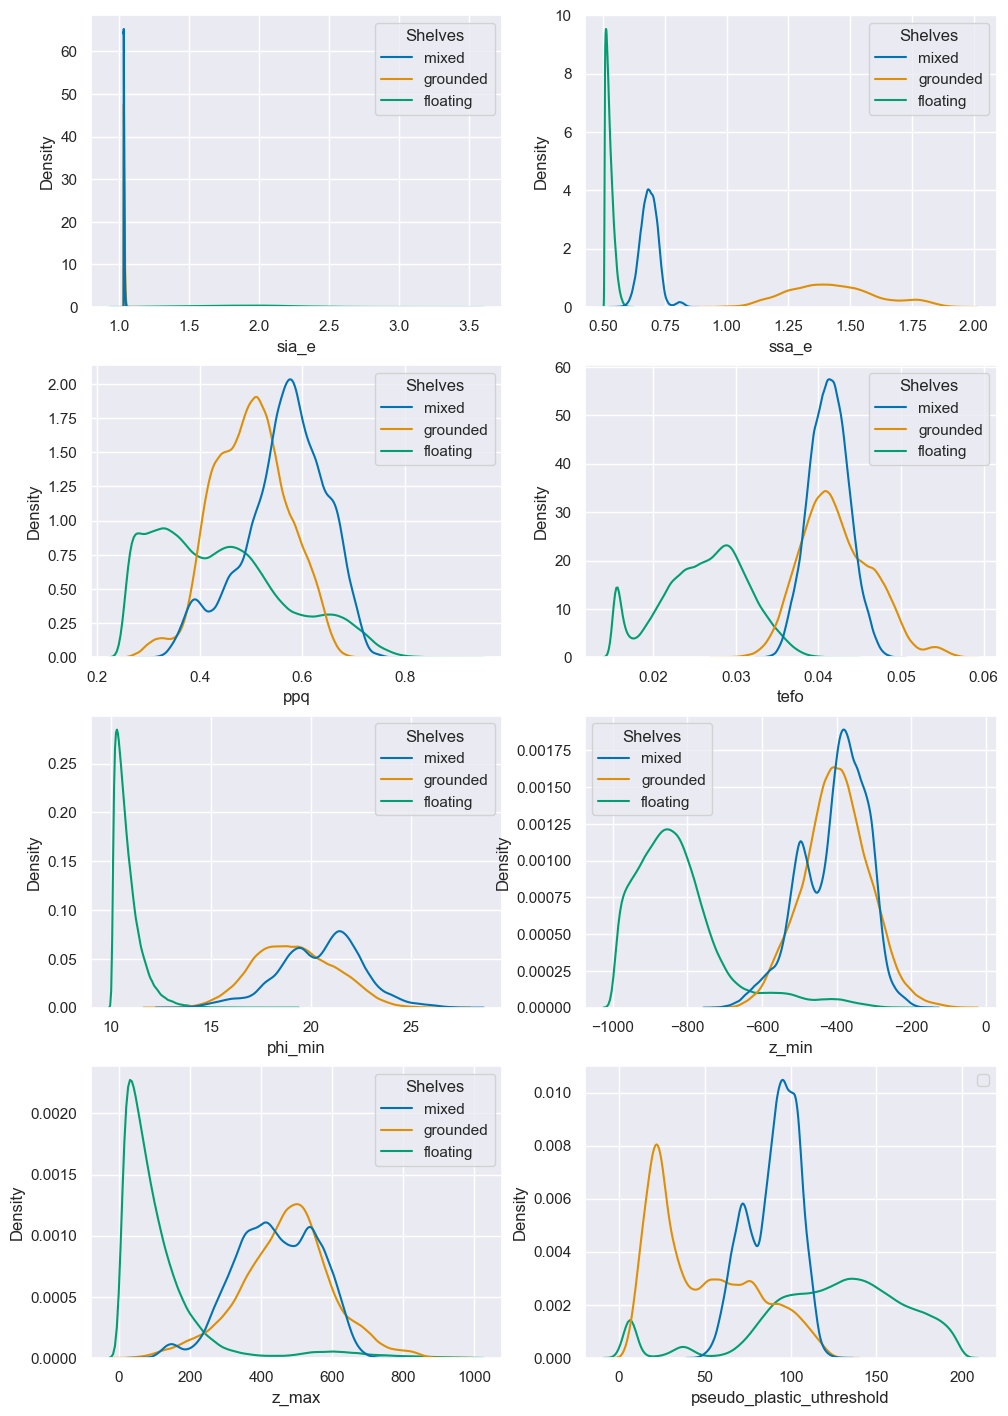

In [31]:
plot_posteriors_shelves(df=plot_df, vars=X_keys, labels="Shelves")

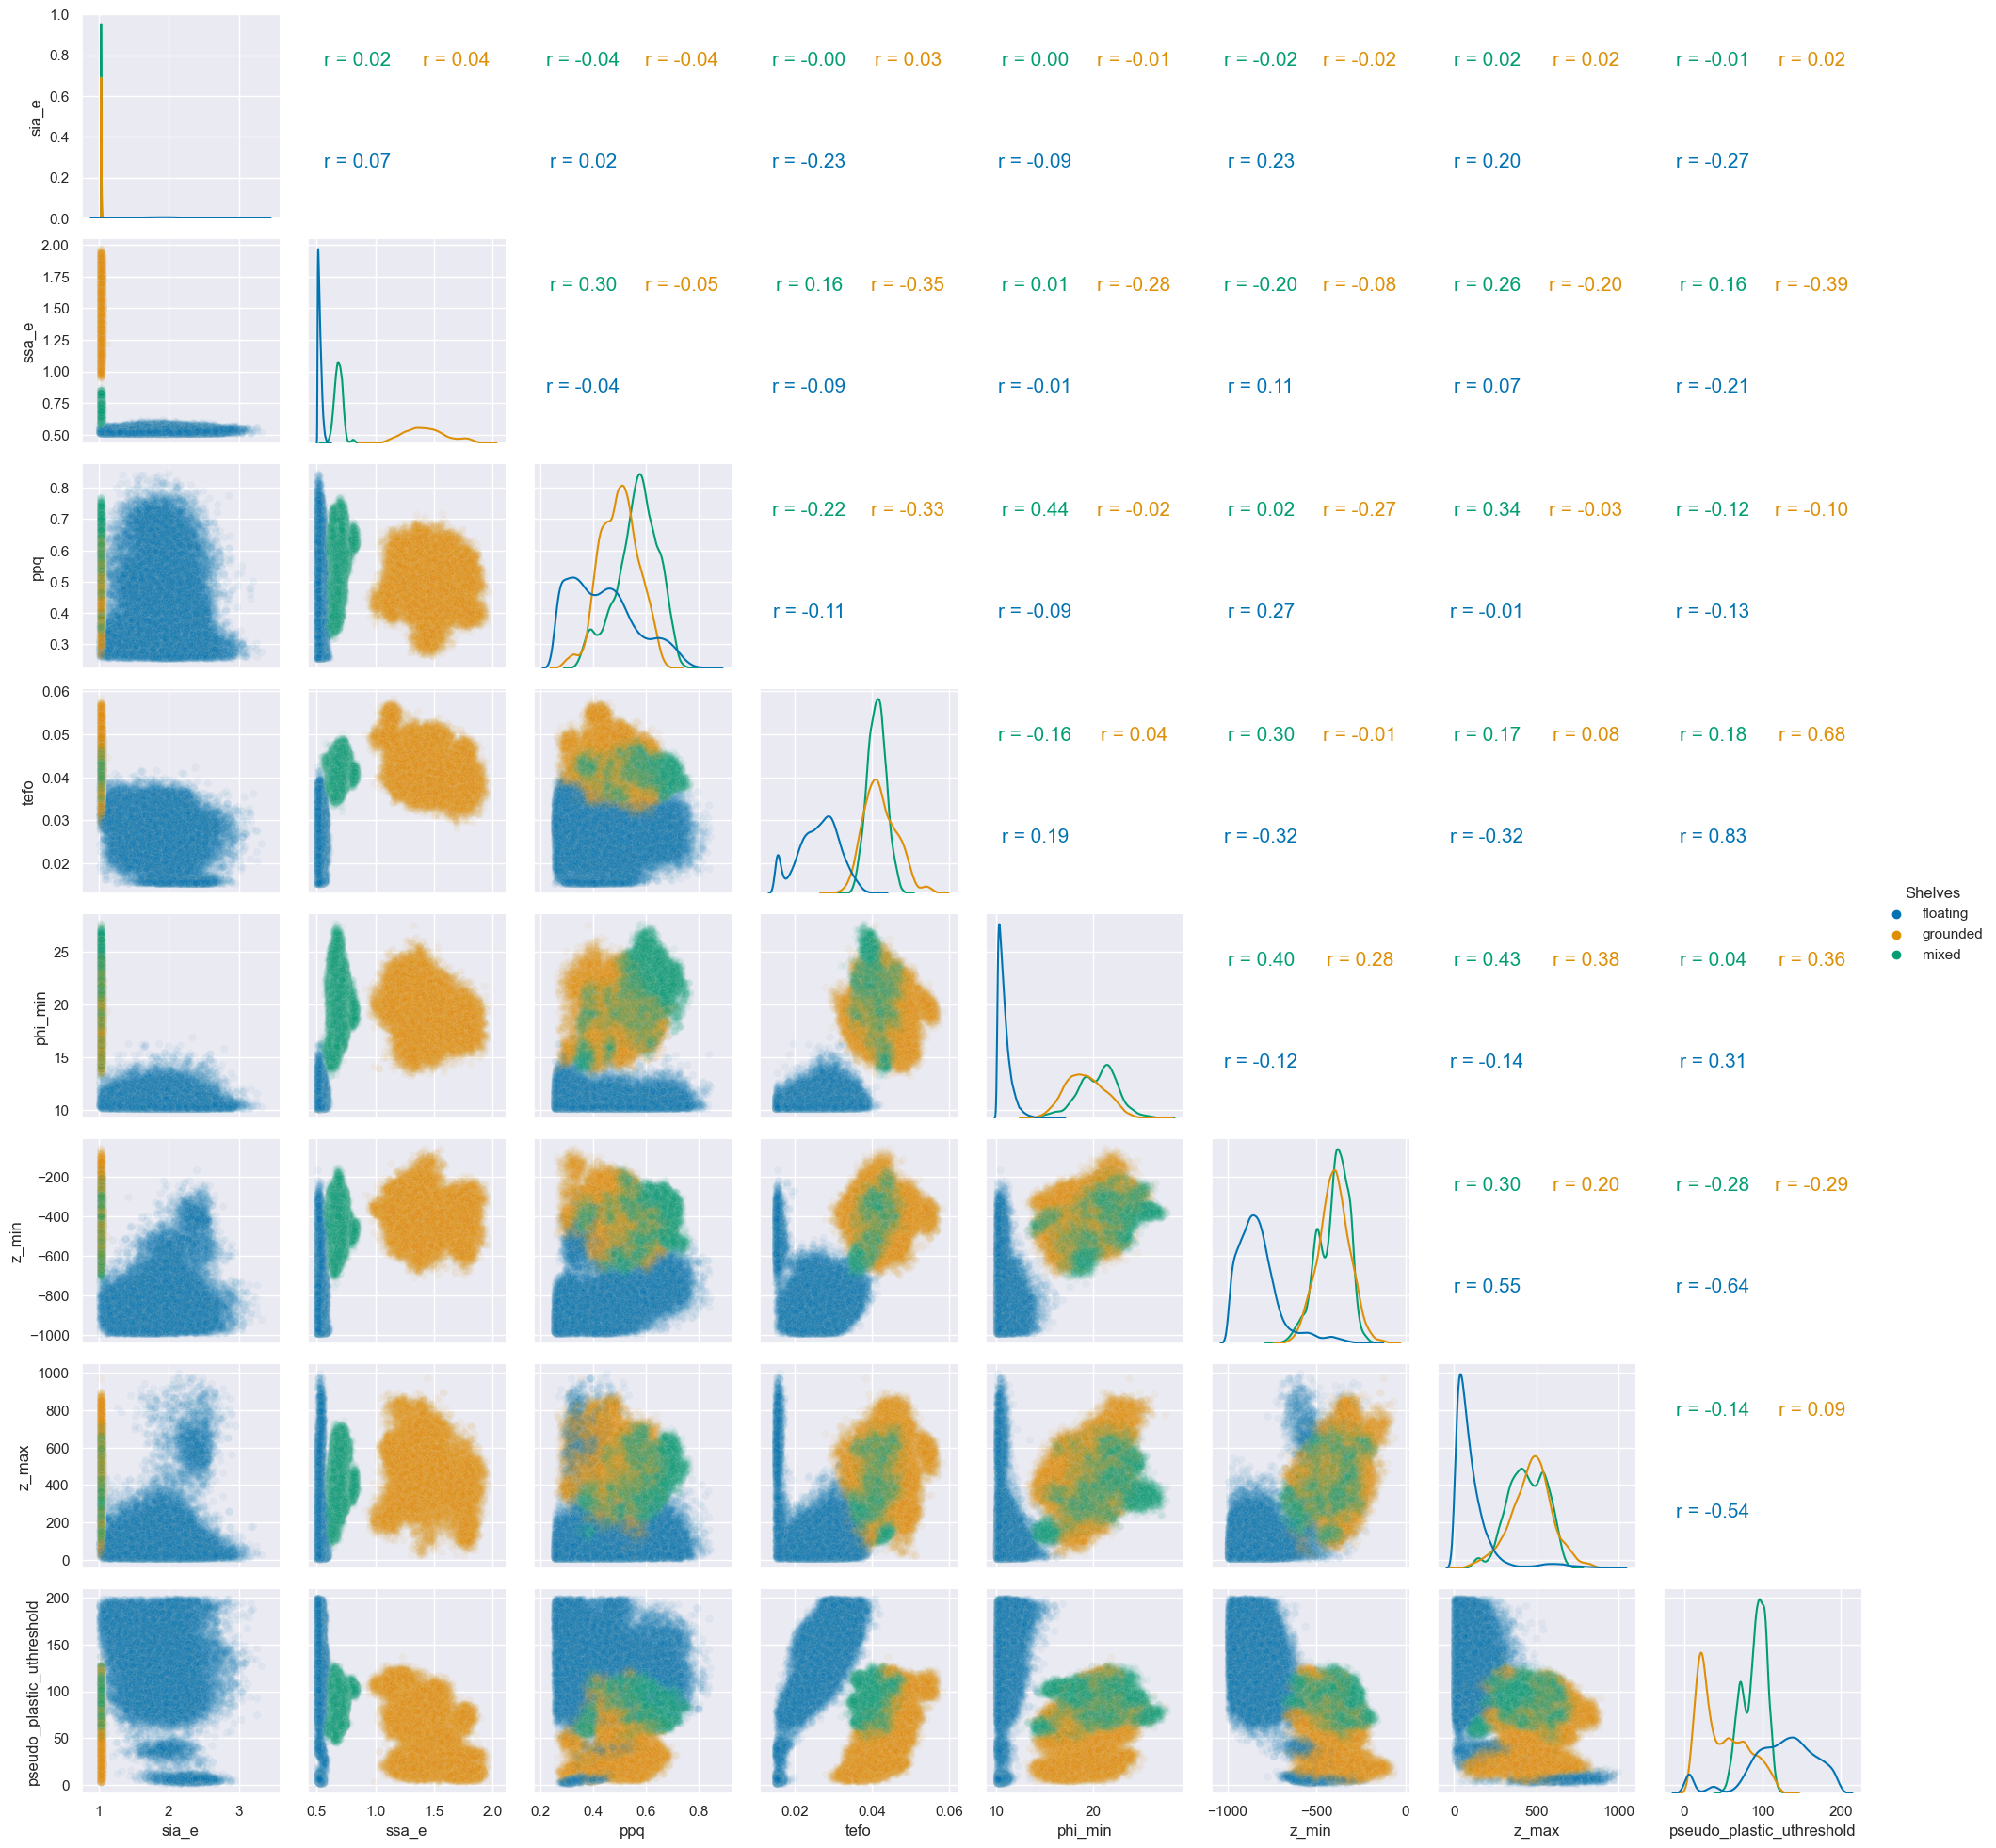

In [19]:
g = sns.PairGrid(plot_df,diag_sharey=False,hue='Shelves')
g.map_diag(sns.kdeplot)
g.map_lower(sns.scatterplot,alpha=.05)
#g.map_lower(sns.kdeplot, levels=1,color='black')
g.add_legend()
g.map_upper(reg_coef)
#g.fig.set_size_inches(12,12)

In [ ]:
np.mean(posterior_dfs[0][X_keys])

/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


sia_e                          1.041648
ssa_e                          0.722617
ppq                            0.527868
tefo                           0.039925
phi_min                       19.351145
z_min                       -414.964564
z_max                        460.598994
pseudo_plastic_uthreshold     91.713025
dtype: float64

In [ ]:
np.mean(posterior_dfs[1][X_keys])

sia_e                          1.050137
ssa_e                          1.283399
ppq                            0.590084
tefo                           0.038929
phi_min                       19.230024
z_min                       -406.572807
z_max                        434.699766
pseudo_plastic_uthreshold     57.173205
dtype: float64